In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis

In [2]:
#get data - store in a zip file and open here, downloaded from the CFPB database. 
#saved this file locally as it is too large for Github, can do the same on your machines if you want to run
df = pd.read_csv("complaints.csv")

In [3]:
#drop rows w/o a consumer complaint narrative (consistent with EDA)
df.dropna(subset = ['Consumer complaint narrative'], inplace=True)

In [4]:
#consistent w/ EDA analysis
new_names = [n.lower().replace(" ", "_").replace("?", "") for n in df.columns]
df.columns = new_names

In [5]:
#create df with complaint id and narrative, as we are performing topic modeling on the text only
df2 = df[['complaint_id', 'consumer_complaint_narrative']].copy()

Steps:
1) convert to lowercase
2) remove special characters and tokenize them into terms
3) remove stop words
4) stemming 
5) construct term-document matrix

Steps based on file:///Users/norahajjar/Downloads/Latent_Dirichlet_Allocation_LDA_for_Topic_Modeling.pdf
Cleaning code based on: https://ashwin-ks.github.io/2018-08-15-NLP-Consumer-Complaints-Classification-ML-DL/

In [6]:
# Remove punctuation, convert to lowercase, remove stop words, remove redacted/x'ed out terms
stop = stopwords.words('english')
df2['consumer_complaint_narrative'] = df2['consumer_complaint_narrative'] \
.map(lambda x: re.sub(r'[,/)(\.!?]', '', x)) \
.map(lambda x: x.lower()) \
.apply(lambda x: ' '.join([i for i in x.split() if i not in stop])) \
.str.replace(r"xx+\s","")

In [7]:
df2.consumer_complaint_narrative.head(1)

0    transworld systems inc trying collect debt min...
Name: consumer_complaint_narrative, dtype: object

In [8]:
#standardize text
#use external normalization dictionaries
#Below, we used three normalizazion dictionaries from these links :
#http://people.eng.unimelb.edu.au/tbaldwin/etc/emnlp2012-lexnorm.tgz
#http://luululu.com/tweet/typo-corpus-r1.txt
dico = {}
dico2 = open('emnlp_dict.txt', 'rb')
for word in dico2:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico2.close()
dico3 = open('typo-corpus-r1.txt', 'rb')
for word in dico3:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico3.close()

In [9]:
def txt_std(words):
    list_words = words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i] = dico[list_words[i]]
    return ' '.join(list_words)

In [10]:
df2['consumer_complaint_narrative'] = df2['consumer_complaint_narrative'].apply(txt_std)

In [11]:
#remove stop words again
stop = stopwords.words('english')
df2['consumer_complaint_narrative'] = df2['consumer_complaint_narrative'] \
.apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))

In [12]:
test = df2.consumer_complaint_narrative.head(20)
test

0     transworld systems trying collect debt mine ow...
2     would like request suppression following items...
3     past 2 weeks receiving excessive amounts telep...
11    sold access event digitally screenshots detail...
12    checking credit report noticed three collectio...
14    today went onlien dispute incorrect personal i...
16    reporting incorrectly equifax account balance ...
17    please reverse late payments reported followin...
18    would like credit bureau correct balance corre...
19    name live dob us addresses file mine please re...
20    three credit bureaus still putting fraud alert...
22    already tried contact company following compla...
23    spoke xxxx19 cat transition refused remove una...
24              victim identity theft previously stated
25    navient failed validate accounts credit report...
28    would like request suppression following items...
29    accounts added andor created unbeknownst notic...
30    credit bureaus reporting inaccurateoutdate

In [13]:
#remove Xs, special characters, numbers
df2['consumer_complaint_narrative'] = df2['consumer_complaint_narrative'] \
.map(lambda x: re.sub(r'x+', '', x)) \
.map(lambda x: re.sub(r'[,/)(\.!?]', '', x)) \
.map(lambda x: re.sub(r'\d', '', x))

In [14]:
df2.head()

,complaint_id,consumer_complaint_narrative
0,3384392,transworld systems trying collect debt mine ow...
2,3417821,would like request suppression following items...
3,3433198,past weeks receiving ecessive amounts telepho...
11,3366475,sold access event digitally screenshots detail...
12,3385399,checking credit report noticed three collectio...


In [15]:
#list of words for wordcloud
words = ','.join(list(df2['consumer_complaint_narrative'].values))

In [16]:
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

In [17]:
#takes time
wordcloud.generate(words)
wordcloud.to_image()

In [18]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, color='blue')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

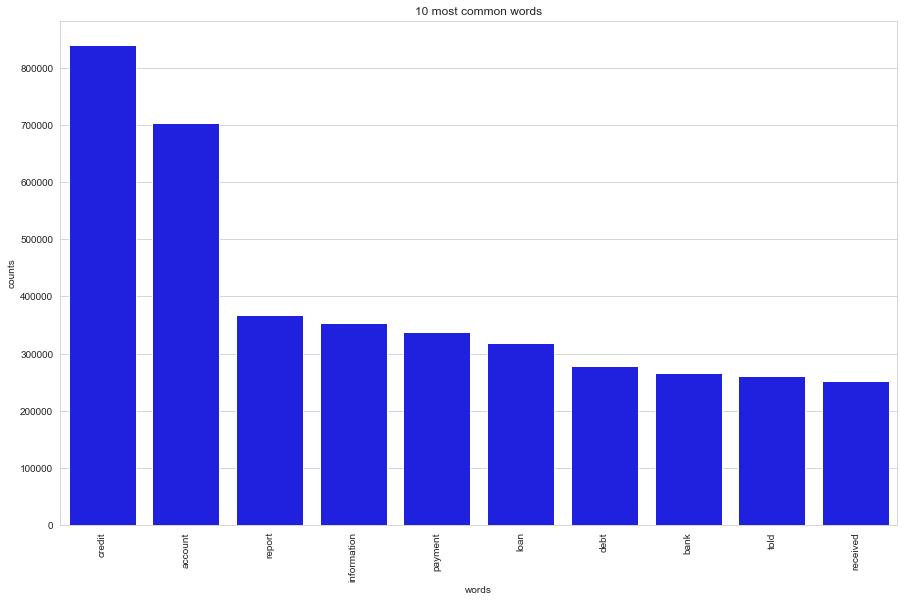

In [19]:
#create BoW
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(df2['consumer_complaint_narrative'])

# Visualise the 10 most common words w/ helper function
plot_10_most_common_words(count_data, count_vectorizer)

There are several existing algorithms you can use to perform the topic modeling. The most common of it are:
Latent Semantic Analysis (LSA/LSI), 
Probabilistic Latent Semantic Analysis (pLSA), and 
Latent Dirichlet Allocation (LDA)
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [20]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Update two parameters below
number_topics = 10
number_words = 5

# Create and fit the LDA model
lda1 = LDA(n_components=number_topics, n_jobs=-1)
lda1.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda1, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
mortgage loan home property insurance

Topic #1:
told said called money asked

Topic #2:
bank loan payment account mortgage

Topic #3:
consumer information identity theft section

Topic #4:
loan loans payment pay payments

Topic #5:
credit report information equifa inquiry

Topic #6:
account card bank credit chase

Topic #7:
debt credit collection account letter

Topic #8:
payment credit late payments paid

Topic #9:
account credit reporting report information


In [21]:
pyLDAvis.enable_notebook()
LDAvis_prepared1 = sklearn_lda.prepare(lda1, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared1)

In [22]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda2 = LDA(n_components=number_topics, n_jobs=-1)
lda2.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda2, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
credit told report called company received said information account phone

Topic #1:
loan payment mortgage payments home time loans pay told paid

Topic #2:
account card credit payment bank balance late days closed charge

Topic #3:
bank money debt check phone number told called account received

Topic #4:
credit report information reporting account debt consumer accounts collection file


In [23]:
pyLDAvis.enable_notebook()
LDAvis_prepared2 = sklearn_lda.prepare(lda2, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared2)

In [24]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda3 = LDA(n_components=number_topics, n_jobs=-1)
lda3.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda3, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
credit inquiry card score report inquiries hard points applied application

Topic #1:
information consumer reporting section credit identity act theft agency report

Topic #2:
mortgage loan home modification property foreclosure sale bankruptcy documents ocwen

Topic #3:
debt collection company letter received credit sent account agency owe

Topic #4:
payment payments pay loan late month time loans paid make

Topic #5:
information complaint security financial fraud personal case cfpb bank law

Topic #6:
loan payment mortgage payments insurance received escrow paid company time

Topic #7:
told called said phone number asked money wells fargo check

Topic #8:
account bank card balance chase payment credit charge charges received

Topic #9:
credit report account reporting information accounts removed reported equifa bureaus


In [25]:
pyLDAvis.enable_notebook()
LDAvis_prepared3 = sklearn_lda.prepare(lda3, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared3)

In [26]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 20
number_words = 1

# Create and fit the LDA model
lda4 = LDA(n_components=number_topics, n_jobs=-1)
lda4.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda4, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
service

Topic #1:
wells

Topic #2:
credit

Topic #3:
car

Topic #4:
mortgage

Topic #5:
law

Topic #6:
debt

Topic #7:
claim

Topic #8:
payment

Topic #9:
debt

Topic #10:
credit

Topic #11:
bank

Topic #12:
credit

Topic #13:
consumer

Topic #14:
told

Topic #15:
card

Topic #16:
loan

Topic #17:
credit

Topic #18:
phone

Topic #19:
loan


In [29]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda4, count_vectorizer, 20)

Topics found via LDA:

Topic #0:
service customer gmail time website issue onlien services company order customers process provided response business support free complaint received able

Topic #1:
wells fargo account money charges bank charge transaction card fees transactions refund charged dispute overdraft fee debit told claim fraud

Topic #2:
credit report information identity theft equifa fraudulent fraud accounts security police victim address social account file personal remove opened inquiries

Topic #3:
car vehicle pal credit lease financial payments loan finance dealership days ally paid santander payment auto insurance report dealer account

Topic #4:
mortgage insurance loan escrow home property bankruptcy company paid payment ta payments taes sent pay received house lien years year

Topic #5:
law state court legal complaint federal act cfpb attorney case note action financial fraud states filed violation practices false agreement

Topic #6:
debt collection owe agency paid 

In [28]:
pyLDAvis.enable_notebook()
LDAvis_prepared4 = sklearn_lda.prepare(lda4, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared4)

In [30]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 6
number_words = 10

# Create and fit the LDA model
lda5 = LDA(n_components=number_topics, n_jobs=-1)
lda5.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda5, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
credit account report reporting information late reported balance dispute removed

Topic #1:
debt phone called company told number received said information asked

Topic #2:
credit report inquiry accounts card inquiries information equifa fraud fraudulent

Topic #3:
information consumer debt reporting credit section agency provide report act

Topic #4:
loan mortgage payment payments home loans time pay told modification

Topic #5:
account bank card payment told money check called time received


In [32]:
pyLDAvis.enable_notebook()
LDAvis_prepared5 = sklearn_lda.prepare(lda5, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared5)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-3cf11c967497>", line 2, in <module>
    LDAvis_prepared5 = sklearn_lda.prepare(lda5, count_data, count_vectorizer)
  File "/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/sklearn.py", line 94, in prepare
    opts = fp.merge(_extract_data(lda_model, dtm, vectorizer), kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/sklearn.py", line 53, in _extract_data
    doc_topic_dists = _get_doc_topic_dists(lda_model, dtm)
  File "/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/sklearn.py", line 30, in _get_doc_topic_dists
    return _row_norm(lda_model.transform(dtm))
  File "/opt/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/_lda.py", line 643, in transform
    doc_topic_distr = self._unnormalized_transform(X)
  File "/opt/anaconda3/lib

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 8
number_words = 10

# Create and fit the LDA model
lda6 = LDA(n_components=number_topics, n_jobs=-1)
lda6.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda6, count_vectorizer, number_words)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared6 = sklearn_lda.prepare(lda6, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared6)